# PHI Data Request

The purpose of this notebook is to generate heat metrics for all of CA within four 30-year target periods.

## 0. Parameters

- Downscaling: LOCA2

- Temporal scale: Annual

- Time periods: 1 value per 30 year spread

    - Past (1961-1990)

    - Current (2005-2034) 
    
    - Mid-century (1935-1964)

    - End-century (2070-2099) 

- Variable: Average (across models) count of days with maximum temperature over <threshold> per time period

    - 90°

    - 100°
    
    - extreme heat days over 98th percentile 

    - warm nights over 98th percentile

- GCMs: All

- SSPs: 5.85

- Format: NetCDF or Geotiff

## 1. Setup

In [ ]:
import climakitae as ck
from climakitae.core.data_interface import (
    get_data_options,
    get_subsetting_options,
    get_data,
)
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd

In [ ]:
# select the mode to run in here
## "test" mode retrieves data for 5-year test periods, and for the smallest CA county
## "full_run" mode retrieves data meeting the complete data request criteria - all of CA, for the four 30-year target periods

mode = "full_run"  # 'test' or 'full_run'

In [ ]:
test_time_slices_dict = {
    "test1": (1995, 2000),
    "test2": (2005, 2010)
}

time_slices_dict = {
    "past": (1961, 1990),
    "current": (2005, 2034),
    "mid-century": (2035, 2064),
    "end-century": (2070, 2099),
}

if mode == 'test':
    area = "San Francisco County"
    dict_slices_run = test_time_slices_dict
elif mode == 'full_run':
    area = "CA"
    dict_slices_run = time_slices_dict


if mode == "test":
    area = "San Francisco County"
    dict_slices_run = test_time_slices_dict
elif mode == "full_run":
    area = "CA"
    dict_slices_run = time_slices_dict

# parameters
max_temp_params = {
    "variable": "Maximum air temperature at 2m",
    "resolution": "3 km",  # CHANGE ME
    "timescale": "daily",
    "downscaling_method": "Statistical",
    "scenario": ["Historical Climate", "SSP 5-8.5"],
    "units": "degF",
    # "time_slice": ()
    "cached_area": area,
}

min_temp_params = {
    "variable": "Minimum air temperature at 2m",
    "resolution": "3 km",  # CHANGE ME
    "timescale": "daily",
    "downscaling_method": "Statistical",
    "scenario": ["Historical Climate", "SSP 5-8.5"],
    "units": "degF",
    # "time_slice": ()
    "cached_area": area,
}

hist_max_temp_params = {
    "variable": "Maximum air temperature at 2m",
    "resolution": "3 km",  # CHANGE ME
    "timescale": "daily",
    "downscaling_method": "Statistical",
    "scenario": ["Historical Climate"],
    "units": "degF",
    # "time_slice": ()
    "cached_area": area,
}

hist_min_temp_params = {
    "variable": "Minimum air temperature at 2m",
    "resolution": "3 km",  # CHANGE ME
    "timescale": "daily",
    "downscaling_method": "Statistical",
    "scenario": ["Historical Climate"],
    "units": "degF",
    # "time_slice": ()
    "cached_area": area,
}

## 2. Functions

The following functions are used to calculate

- average annual number of extreme heat days above 90 deg F
- average annual number of extreme heat days above 100 deg F
- average annual number of extreme heat days above historical baseline (98th percentile)
- average annual number of warm nights (based on historical 98th percentile)


In [ ]:
# extreme heat days above given temperature threshold

def avg_days_above_X_degF(data, temp_threshold_in_degF):
    return (data.mean('simulation') > temp_threshold_in_degF).groupby('time.year').sum('time').mean('year').squeeze()

In [ ]:
# extreme heat days or warm nights above historical baseline (98th percentile)

def avg_days_above_percentile(hist_data, data, percentile):

    # select April through October over which to compute the 98th percentile
    months_to_measure = [m for m in np.arange(4, 11, 1)]

    # compute 98th percentile historical temperature between April and October
    hist_thresh = (
        hist_data.sel(time=hist_data.time.dt.month.isin(months_to_measure))
        .quantile(percentile, dim="time") # most computationally intense
    )
    
    # select out scenario to reduce complexity
    data = data.isel(scenario = 0)

    # count total days > 98th percentile in historical data and take average across time slice
    hist_count = (
        xr.where(data > hist_thresh, x=1, y=0)
        .groupby("time.year")
        .sum("time")
        .mean(dim="year")
        .mean(dim="simulation")
        .squeeze()
    )

    return hist_count

## 3. Generate metrics

### Average annual number of extreme heat days above 90 deg F

In [ ]:
temp_threshold = 90

results = []

for label, time_slice in dict_slices_run.items():

    # retrieve data
    data = get_data(**max_temp_params, time_slice=time_slice)

    # for that time slice, calculate the average number of days above a temperature threshold in the time slice
    result = avg_days_above_X_degF(data, temp_threshold_in_degF=temp_threshold)
    print()

    # add time slice name as a dimension
    result = result.expand_dims({"time_slice_name": [label]})

    # now append this result to the ongoing list of results
    results.append(result)

# concatenate all along the new "time_slice_name" dimension
combined_90 = xr.concat(results, dim="time_slice_name")

# add in the time ranges to the dataset coordinates
combined_90 = combined_90.assign_coords(
    {
        "time_slice_range": (
            "time_slice_name",
            [f"{t[0]}–{t[1]}" for t in dict_slices_run.values()],
        )
    }
)

# rename
combined_90.name = f"avg annual # extreme heat days above {temp_threshold} F"

# export to local, as netCDF
combined_90.to_netcdf(
    path=f"avg_extreme_heat_days_over_{temp_threshold}.nc", engine="netcdf4"
)

### Average annual number of extreme heat days above 100 deg F

In [ ]:
temp_threshold = 100

results = []

for label, time_slice in dict_slices_run.items():

    # retrieve data
    data = get_data(**max_temp_params, time_slice=time_slice)

    # for that time slice, calculate the average number of days above a temperature threshold in the time slice
    result = avg_days_above_X_degF(data, temp_threshold_in_degF=temp_threshold)
    print()

    # add time slice name as a dimension
    result = result.expand_dims({"time_slice_name": [label]})

    # now append this result to the ongoing list of results
    results.append(result)

# concatenate all along the new "time_slice_name" dimension
combined_100 = xr.concat(results, dim="time_slice_name")

# add in the time ranges to the dataset coordinates
combined_100 = combined_100.assign_coords(
    {
        "time_slice_range": (
            "time_slice_name",
            [f"{t[0]}–{t[1]}" for t in dict_slices_run.values()],
        )
    }
)

# rename
combined_100.name = f"avg annual # extreme heat days above {temp_threshold} F"

# export to local, as netCDF
combined_100.to_netcdf(path=f"avg_extreme_heat_days_over_{temp_threshold}.nc", engine="netcdf4")

### Average annual number of extreme heat days above historical baseline (98th percentile)

In [ ]:
# retrieve historical data to use as baseline
hist_data = get_data(**hist_max_temp_params, time_slice=(1981, 2010))

In [ ]:
percentile = 0.98
results = []

for label, time_slice in dict_slices_run.items():

    # retrieve data
    data = get_data(**max_temp_params, time_slice=time_slice)

    # for that time slice, calculate the average number of days above 98th percentile in the time slice
    result = avg_days_above_percentile(hist_data, data, percentile)

    # add time slice name as a dimension
    result = result.expand_dims({"time_slice_name": [label]})

    # now append this result to the ongoing list of results
    results.append(result)

print("iterative counts complete")

# concatenate all along the new "time_slice_name" dimension
combined_hot = xr.concat(results, dim="time_slice_name")

# add in the time ranges to the dataset coordinates
combined_hot = combined_hot.assign_coords(
    {
        "time_slice_range": (
            "time_slice_name",
            [f"{t[0]}–{t[1]}" for t in dict_slices_run.values()],
        )
    }
)

print("concatenation complete")

# rename variable
combined_hot.name = "avg annual # extreme heat days above 98th percentile"

### Average annual number of warm nights (based on historical 98th percentile)

In [ ]:
# retrieve historical data  to use as baseline
hist_data = get_data(**hist_min_temp_params, time_slice=(1981, 2010))

In [ ]:
percentile = 0.98
results = []

for label, time_slice in dict_slices_run.items():

    # retrieve data
    data = get_data(**min_temp_params, time_slice=time_slice)

    # Apply the temperature function
    result = avg_days_above_percentile(hist_data, data, percentile)

    # Optionally attach a coordinate for the label (for clarity)
    result = result.expand_dims({"time_slice_name": [label]})

    # Collect for concatenation
    results.append(result)

# Concatenate all along the new "time_slice" dimension
combined_warm = xr.concat(results, dim="time_slice_name")

# Now add in the time ranges to the dataset coordinates
combined_warm = combined_warm.assign_coords(
    {
        "time_slice_range": (
            "time_slice_name",
            [f"{t[0]}–{t[1]}" for t in dict_slices_run.values()],
        )
    }
)

combined_warm.name = "avg annual # warm nights above 98th percentile"

# # export to local, as netCDF
# combined_warm.to_netcdf(
#     path=f"avg_warm_nights_above_98th_percentile.nc", engine="netcdf4"
# )

## 4. Visualize results

To visualize the metrics, you will need to select the variable in the output datasets that they are stored in. Make sure that the datasets are stored in the same place as this noteook.

In [ ]:
# first, import from local
above_90 = xr.open_dataset("avg_extreme_heat_days_over_90.nc", engine="netcdf4")
above_100 = xr.open_dataset("avg_extreme_heat_days_over_100.nc", engine="netcdf4")
extreme_heat = xr.open_dataset(
    "avg_extreme_heat_days_above_98th_percentile.nc", engine="netcdf4"
)
warm_nights = xr.open_dataset(
    "avg_warm_nights_above_98th_percentile.nc", engine="netcdf4"
)

In [ ]:
# choose which time slice you would like to visualize
# OPTIONS:
# 'past'
# 'current'
# 'mid-century'
# 'late-century'

time_slice = 'mid-century'

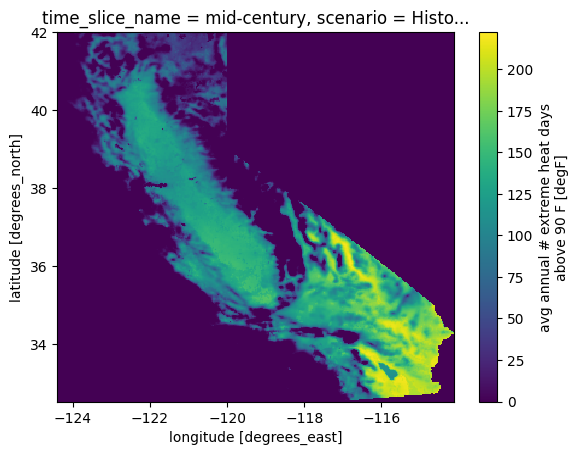

In [18]:
# average days over 90 F for the selected time slice

above_90.sel(time_slice_name=time_slice)[
    "avg annual # extreme heat days above 90 F"
].squeeze().plot()

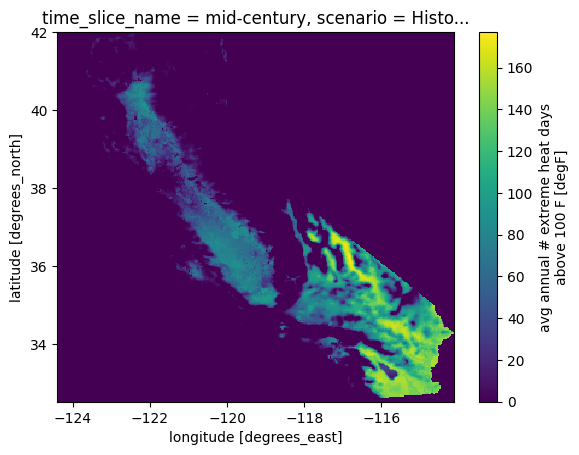

In [20]:
# average days over 100 F for the selected time slice

above_100.sel(time_slice_name=time_slice)[
    "avg annual # extreme heat days above 100 F"
].squeeze().plot()

In [ ]:
# average extreme heat days over the 98th percentile for the selected time slice

extreme_heat.sel(time_slice_name=time_slice)[
    "avg annual # extreme heat days above 98th percentile"
].squeeze().plot()

In [ ]:
# average warm nights over the 98th percentile for the selected time slice

warm_nights.sel(time_slice_name=time_slice)[
    "avg annual # warm nights above 98th percentile"
].squeeze().plot()

## 5. Convert to census tract level

In [ ]:
def reproject_to_tracts(ds_delta, ca_boundaries):
    df = ds_delta.to_dataframe().reset_index()
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y))
    gdf = gdf.set_crs(crs)
    gdf = gdf.to_crs(ca_boundaries.crs)

    ca_boundaries = ca_boundaries.set_index(["GEOID"])

    clipped_gdf = gpd.sjoin_nearest(ca_boundaries, gdf, how="left")
    clipped_gdf = clipped_gdf.drop(["index_right"], axis=1)
    clipped_gdf = clipped_gdf.reset_index()[["GEOID", f"{ds_delta.name}", "geometry"]]

    ### some coastal tracts do not contain any land grid cells ###
    ### due to the WRF's underlying surface type for a given grid cell. ###

    # aggregate the gridded data to the tract level
    clipped_gdf_diss = clipped_gdf.reset_index().dissolve(by="GEOID", aggfunc="mean")
    clipped_gdf_diss = clipped_gdf_diss.rename(
        columns={f"{ds_delta.name}_right": ds_delta.name}
    )

    # separate tracts with data from tracts without data
    clipped_gdf_nan = clipped_gdf_diss[np.isnan(clipped_gdf_diss[ds_delta.name])]
    clipped_gdf_nan = clipped_gdf_nan[["geometry", ds_delta.name]]
    clipped_gdf_valid = clipped_gdf_diss[~np.isnan(clipped_gdf_diss[ds_delta.name])]
    clipped_gdf_valid = clipped_gdf_valid[["geometry", ds_delta.name]]

    # compute the centroid of each tract
    clipped_gdf_nan["centroid"] = clipped_gdf_nan.centroid
    clipped_gdf_nan = clipped_gdf_nan.set_geometry("centroid")
    clipped_gdf_valid["centroid"] = clipped_gdf_valid.centroid
    clipped_gdf_valid = clipped_gdf_valid.set_geometry("centroid")

    # fill in missing tracts with values from the closest tract
    # in terms of distance between the tract centroids
    clipped_gdf_filled = clipped_gdf_nan.sjoin_nearest(clipped_gdf_valid, how="left")
    clipped_gdf_filled = clipped_gdf_filled[["geometry_left", f"{ds_delta.name}_right"]]
    clipped_gdf_filled = clipped_gdf_filled.rename(
        columns={"geometry_left": "geometry", f"{ds_delta.name}_right": ds_delta.name}
    )
    clipped_gdf_valid = clipped_gdf_valid.drop(columns="centroid")

    # concatenate filled-in tracts with the original tract which had data
    gdf_all_tracts = pd.concat([clipped_gdf_valid, clipped_gdf_filled])

    return gdf_all_tracts

In [ ]:
reproject_test = reproject_to_tracts(over_90, ca_boundaries)